<a href="https://colab.research.google.com/github/OctavioGuaschi/IA901-2023S1/blob/main/projetos/Human_physical_position_detection/notebooks/Ex06_264521.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
data_dir = "gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset"

Mounted at /content/gdrive


# Deep Learning para detecção de tumores no cérebro

In [ ]:
# Imports

# import the needed libs

from __future__ import print_function, division

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## Carregar dados

Este código carrega imagens 2D de cérebros saudáveis e cérebros contendo tumores usando um dataloader.

In [ ]:

config={
        "epochs": 25,
        "batch_size": 48,
        "lr": 8e-4,
}


In [ ]:
class ImageFolderWithPath(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, path

In [ ]:
# Data augmentation and normalization for training

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((170,170)),
        torchvision.transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0., saturation=0., hue=0.),
        transforms.RandomRotation(90),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize((170,170)),
        torchvision.transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0., saturation=0., hue=0.),
        transforms.RandomRotation(90),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.ToTensor()
    ])
}

image_datasets = {x: ImageFolderWithPath(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=48, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

# Train 143 (56,5%), Val 62 (24,5%), Test 48 (19%)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

O dataset utilzado possui limitações em quantidade, tendo uma baixa quantidade para teste e validaçao. Para isso é necessário realizar um data augmentation através das transformações disponíveis no pytorch. Serão feitas transformações aleatórias para cada batch criado, gerando uma dataset mais "variado". As seguintes transformações foram escolhidas:


*   Random rotation: Rotaciona a imagem aleatoriamente, aumentando a generalização por local onde pode estar encontrado, ou seja, informações de onde a detecção alvo está na imagem não importa.
*   GaussianBlur: Esse método é aplicado em todas imagens com intuito de tornar a imagem menos clara e distinta, tornando a rede mais robusta na parte de aprendizado.
*   ColorJitter, brightness random change: No dataset é possível encontrar diferentes imagens, mais claras e mais escuras, variar o brilho aleatoriamente faz com que haja uma maior generalização para todas as imagens, em diferentes situações.








In [ ]:
print(np.shape(image_datasets))

()


In [ ]:
print(dataset_sizes)

{'train': 143, 'val': 62, 'test': 48}


# Visualizando algumas imagens (um batch)

Batch of training data


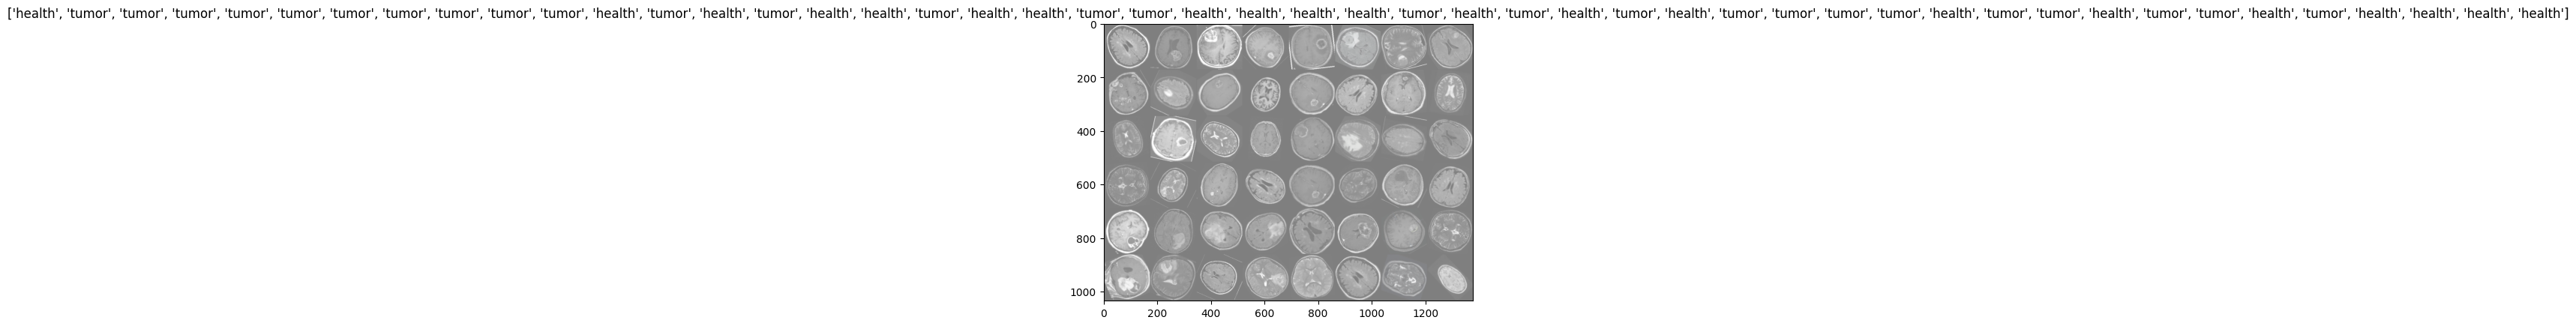

Batch of validation data


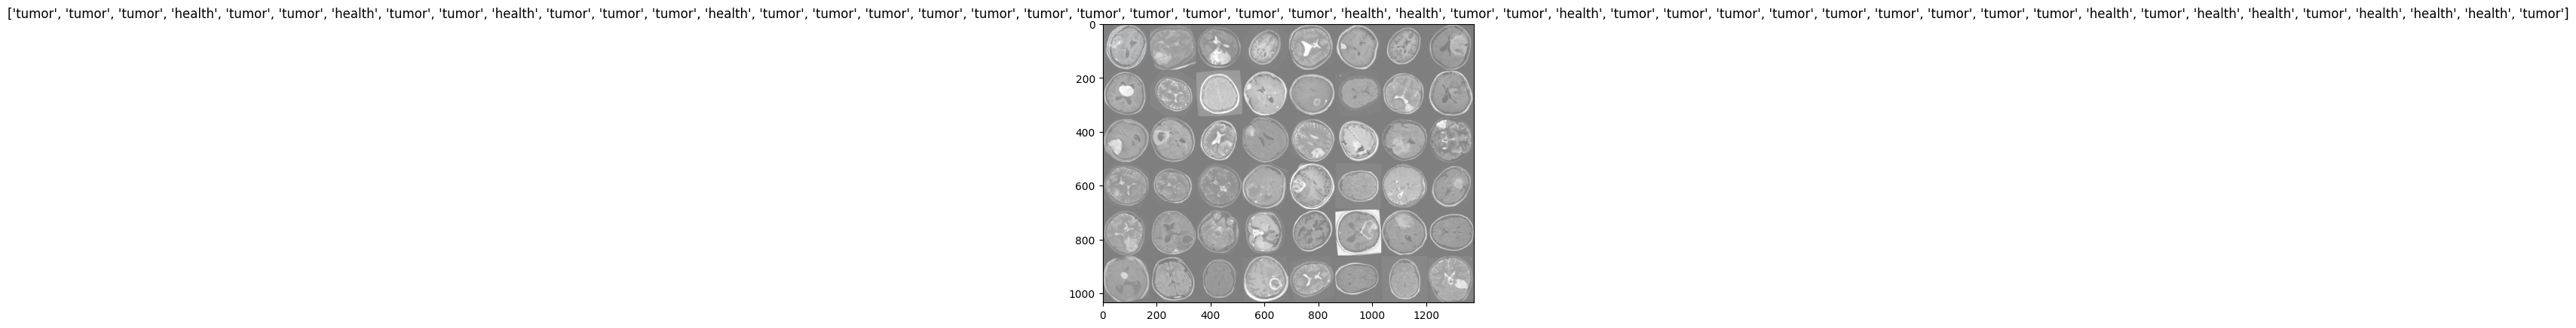

Batch of test data


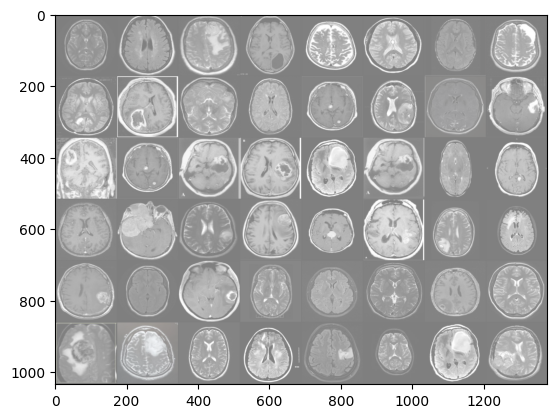

('gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test11.jpg', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test18.jpg', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test46.JPG', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test2.jpg', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test10.JPG', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test36.JPG', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test21.jpg', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test34.JPG', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test44.JPG', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test29.JPG', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/Brain_Tumor_Dataset/test/test/test1.jpg', 'gdrive/MyDrive/P_IA901A_2023S1/IA901A_Ex06/

In [ ]:
#visualize
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


print('Batch of training data')
inputs, classes, _ = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


print('Batch of validation data')
inputs, classes, _ = next(iter(dataloaders['val']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



print('Batch of test data')
inputs, _, paths = next(iter(dataloaders['test']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

print(paths)

In [ ]:
print(np.shape(out))

torch.Size([3, 1034, 1378])


In [ ]:
print(np.shape(inputs))

torch.Size([48, 3, 170, 170])


# Treinando o modelo

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    LOSS_train21 = []
    LOSS_val21 = []
    ACC_train21 = []
    ACC_val21 = []
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                LOSS_train21.append(epoch_loss)
                ACC_train21.append(epoch_acc)
            if phase == 'val':
                LOSS_val21.append(epoch_loss)
                ACC_val21.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, LOSS_train21, ACC_train21, LOSS_val21, ACC_val21;


# Testando o modelo

In [ ]:
def test_model(model, num_images=48):
    was_training = model.training
    model.eval()
    images_so_far = 0


    with torch.no_grad():
        for i, (inputs, _, paths) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                fig = plt.figure(figsize=(50, 50))
                plt.tight_layout()
                plt.subplot(num_images, 1, images_so_far)
                plt.axis('off')
                print('path: {} / predicted: {}'.format(paths[j].split('/')[7], class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Experiment 1

**No transfer learning:** Random initialization and all weights will be retrained.

In [ ]:
#model_ft_randstart = models.resnet18(pretrained=False)
model_ft_randstart1 = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model_ft_randstart2 = models.vgg19(pretrained=True);
model_ft_randstart3 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
model_ft_randstart = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)


#num_ftrs = model_ft_randstart.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#model_ft_randstart.fc = nn.Linear(num_ftrs, 2)
#model_ft_randstart.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ft_randstart = model_ft_randstart.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_randstart = optim.SGD(model_ft_randstart.parameters(), momentum=0.9,lr = 8e-4)
#optimizer_ft_randstart =  optim.Adam(model_ft_randstart.parameters(), lr=8e-5)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=200, gamma=0.5)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 78.8MB/s]
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Ar

In [ ]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

LOSS_train1 = []
LOSS_val1 = []
ACC_train1 = []
ACC_val1 = []

LOSS_train2 = []
LOSS_val2 = []
ACC_train2 = []
ACC_val2 = []

LOSS_train3 = []
LOSS_val3 = []
ACC_train3 = []
ACC_val3 = []

model_ft_randstart, LOSS_train, ACC_train,  LOSS_val, ACC_val  = train_model(model_ft_randstart, criterion, optimizer_ft_randstart, exp_lr_scheduler,
                       num_epochs=16)
model_ft_randstart1 = model_ft_randstart1.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_randstart = optim.SGD(model_ft_randstart1.parameters(), momentum=0.9,lr = 8e-4)
#optimizer_ft_randstart =  optim.Adam(model_ft_randstart.parameters(), lr=8e-5)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=200, gamma=0.5)
model_ft_randstart1, LOSS_train1, ACC_train1,  LOSS_val1, ACC_val1  = train_model(model_ft_randstart1, criterion, optimizer_ft_randstart, exp_lr_scheduler,
                       num_epochs=11)
model_ft_randstart2 = model_ft_randstart2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_randstart = optim.SGD(model_ft_randstart2.parameters(), momentum=0.9,lr = 8e-4)
#optimizer_ft_randstart =  optim.Adam(model_ft_randstart.parameters(), lr=8e-5)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=200, gamma=0.5)
model_ft_randstart2, LOSS_train2, ACC_train2,  LOSS_val2, ACC_val2  = train_model(model_ft_randstart2, criterion, optimizer_ft_randstart, exp_lr_scheduler,
                       num_epochs=14)
model_ft_randstart3 = model_ft_randstart3.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_randstart = optim.SGD(model_ft_randstart3.parameters(), momentum=0.9,lr = 8e-4)
#optimizer_ft_randstart =  optim.Adam(model_ft_randstart.parameters(), lr=8e-5)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=200, gamma=0.5)
model_ft_randstart3, LOSS_train3, ACC_train3,  LOSS_val3, ACC_val3  = train_model(model_ft_randstart3, criterion, optimizer_ft_randstart, exp_lr_scheduler,
                       num_epochs=45)

Epoch 0/15
----------
train Loss: 8.2152 Acc: 0.0140
val Loss: 10.4495 Acc: 0.0000

Epoch 1/15
----------
train Loss: 7.7841 Acc: 0.0210
val Loss: 8.5176 Acc: 0.0000

Epoch 2/15
----------
train Loss: 6.6593 Acc: 0.0420
val Loss: 7.1757 Acc: 0.0000

Epoch 3/15
----------
train Loss: 5.2815 Acc: 0.0769
val Loss: 5.3001 Acc: 0.0161

Epoch 4/15
----------
train Loss: 3.7840 Acc: 0.3147
val Loss: 3.8759 Acc: 0.2419

Epoch 5/15
----------
train Loss: 2.5529 Acc: 0.5524
val Loss: 2.7894 Acc: 0.5161

Epoch 6/15
----------
train Loss: 1.5891 Acc: 0.6993
val Loss: 1.8870 Acc: 0.7097

Epoch 7/15
----------
train Loss: 1.0377 Acc: 0.7552
val Loss: 1.1796 Acc: 0.8226

Epoch 8/15
----------
train Loss: 0.7598 Acc: 0.7832
val Loss: 1.0590 Acc: 0.7903

Epoch 9/15
----------
train Loss: 0.5321 Acc: 0.8252
val Loss: 0.8639 Acc: 0.7903

Epoch 10/15
----------
train Loss: 0.4168 Acc: 0.8531
val Loss: 0.6689 Acc: 0.8387

Epoch 11/15
----------
train Loss: 0.2424 Acc: 0.9161
val Loss: 0.5285 Acc: 0.8710

E

Foram escolhidas algumas redes disponíveis no pytorch:

*   GoogLenet: modelo vencedor do ImageNet 2014, com seu poderoso modelo de 22 camadas, alta velocidade de treinamento em relação a redes como VGG, modelo menor treinado, ou seja, alto desempenho com menor custo.
*   VGG19: Possui 19 camadas, por isso nome. Assim como as outras possui versão pré-treinada com diversas imagens, em 2014, antes do lançamento da googlenet foi vencedora do ImageNet Large-Scale Visual Recognition Challenge (ILSVRC).
*   AlexNet: POssui 8 camadas e em 2012 teve grande destaque no desafio de reconhecimento visual. Quebrando o paradigma de que a rede pode aprender além dos recursos projetados manualmente. Foi sucedida pela VGG e googlenet.
*   EfficientNet: Como o próprio nome fala, tem como seu foco ser eficiente computacionalmente, alcançando um valor alto no ImageNet dataset. Seu uso é mais aconselhado em modelos mais complexos, devido a sua escalabilidade.





In [ ]:
##CONVERTER DE CUDA TENSOR PARA numpy

ACC_train_google = torch.tensor(ACC_train).detach().cpu().numpy()
ACC_val_google =  torch.tensor(ACC_val).detach().cpu().numpy()
ACC_train_alex = torch.tensor(ACC_train1).detach().cpu().numpy()
ACC_val_alex =  torch.tensor(ACC_val1).detach().cpu().numpy()
ACC_train_vgg = torch.tensor(ACC_train2).detach().cpu().numpy()
ACC_val_vgg =  torch.tensor(ACC_val2).detach().cpu().numpy()
ACC_train_efficient = torch.tensor(ACC_train3).detach().cpu().numpy()
ACC_val_efficient =  torch.tensor(ACC_val3).detach().cpu().numpy()


LOSS_train_google = torch.tensor(LOSS_train).detach().cpu().numpy()
LOSS_val_google =  torch.tensor(LOSS_val).detach().cpu().numpy()
LOSS_train_alex = torch.tensor(LOSS_train1).detach().cpu().numpy()
LOSS_val_alex =  torch.tensor(LOSS_val1).detach().cpu().numpy()
LOSS_train_vgg = torch.tensor(LOSS_train2).detach().cpu().numpy()
LOSS_val_vgg =  torch.tensor(LOSS_val2).detach().cpu().numpy()
LOSS_train_efficient = torch.tensor(LOSS_train3).detach().cpu().numpy()
LOSS_val_efficient =  torch.tensor(LOSS_val3).detach().cpu().numpy()


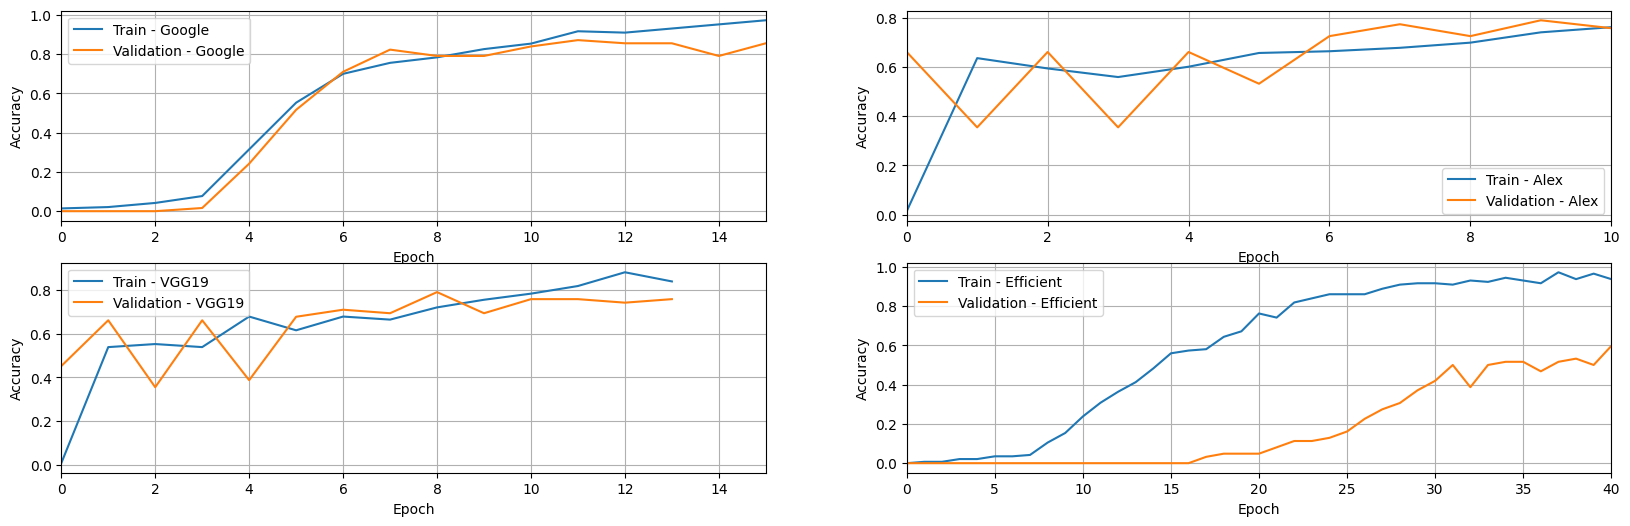

In [ ]:
#Plot accuracy history
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 6))

plt.subplot(221)
plt.plot(ACC_train_google, label = "Train - Google")
plt.plot(ACC_val_google,label = "Validation - Google")

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(0,15)
plt.grid()
plt.subplot(221+1)
plt.plot(ACC_train_alex, label = "Train - Alex")
plt.plot(ACC_val_alex,label = "Validation - Alex")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(0,10)
plt.grid()
plt.subplot(221+2)
plt.plot(ACC_train_vgg, label = "Train - VGG19")
plt.plot(ACC_val_vgg,label = "Validation - VGG19")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(0,15)
plt.grid()
plt.subplot(221+3)
plt.plot(ACC_train_efficient, label = "Train - Efficient")
plt.plot(ACC_val_efficient,label = "Validation - Efficient")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(0,40)
plt.grid()
plt.show()

O gráfico de acurácia não é o melhor recurso visual a ser utilizado, mas é bom para ver o comportamento da rede, para analisar se há um indício de overfitting. Com testes o número de épocas foi limitado para que não haja overfitting. É possível ver que a googlenet, teve uma maior acurácia no conjunto de validação mesmo tendo um alto aprendizado com o dados de treino, mostrando que aprendeu bastante com o dado não utilizado para treino. Todas seguiram um padrão, entretanto a efficient possuiu um valor de acurácia bastante limitado para a validação, mostrando um possível overfitting.

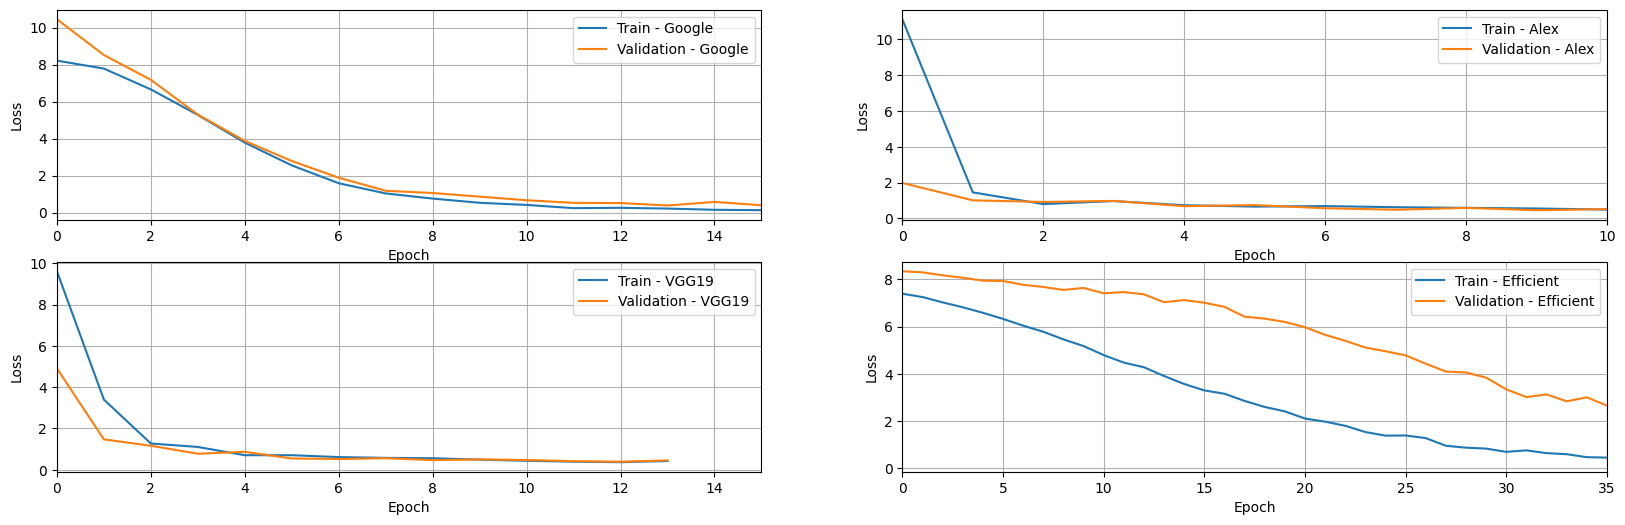

In [ ]:
#Plot LOSS history
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 6))

plt.subplot(221)
plt.plot(LOSS_train_google, label = "Train - Google")
plt.plot(LOSS_val_google,label = "Validation - Google")

plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(0,15)
plt.grid()
plt.subplot(221+1)
plt.plot(LOSS_train_alex, label = "Train - Alex")
plt.plot(LOSS_val_alex,label = "Validation - Alex")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(0,10)
plt.grid()
plt.subplot(221+2)
plt.plot(LOSS_train_vgg, label = "Train - VGG19")
plt.plot(LOSS_val_vgg,label = "Validation - VGG19")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(0,15)
plt.grid()
plt.subplot(221+3)
plt.plot(LOSS_train_efficient, label = "Train - Efficient")
plt.plot(LOSS_val_efficient,label = "Validation - Efficient")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.xlim(0,35)
plt.grid()
plt.show()

O gráfico de loss entrega mais informação que o de acurácia, pois o método de cálculo de loss leva em consideração a probabilidade de cada chute com a probabilidade esperada e então calcula o loss. Ou seja, correlaciona todas as saídas da classificação, no caso 2. Visto isso, no treino de todas, percebe-se que a loss começa com um alto valor e no caso da alex e vgg rapidadmente diminuem o valor da loss, não conseguindo então um ganho de precisão, podendo ter gerado overfitting. Os modelos foram deixados treinando um pouco mais, pois a acurácia estava baixa.

Já no caso da googlenet, percebe-se que ficou menos tempo com a loss quase que constante, minimizando talvez o over fitting. No caso da efficient, diferente do que foi proposto pela rede, esta é a que foi colocada mais tempo treinando e mesmo assim, ainda possui altos valores de loss.

Como decisão, com menor loss e maior acurácia, o modelo utilizado será o googleNEt.

In [ ]:
model_ft_randstart

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
summary(model_ft_randstart, (3, 170, 170))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 85, 85]           9,408
       BatchNorm2d-2           [-1, 64, 85, 85]             128
       BasicConv2d-3           [-1, 64, 85, 85]               0
         MaxPool2d-4           [-1, 64, 42, 42]               0
            Conv2d-5           [-1, 64, 42, 42]           4,096
       BatchNorm2d-6           [-1, 64, 42, 42]             128
       BasicConv2d-7           [-1, 64, 42, 42]               0
            Conv2d-8          [-1, 192, 42, 42]         110,592
       BatchNorm2d-9          [-1, 192, 42, 42]             384
      BasicConv2d-10          [-1, 192, 42, 42]               0
        MaxPool2d-11          [-1, 192, 21, 21]               0
           Conv2d-12           [-1, 64, 21, 21]          12,288
      BatchNorm2d-13           [-1, 64, 21, 21]             128
      BasicConv2d-14           [-1, 64,

path: test41.jpg / predicted: tumor


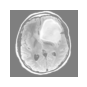

path: test36.JPG / predicted: health


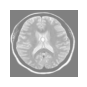

path: test48.JPG / predicted: tumor


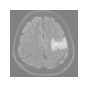

path: test32.JPG / predicted: tumor


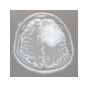

path: test25.jpg / predicted: tumor


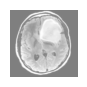

path: test26.jpg / predicted: tumor


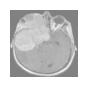

path: test7.JPG / predicted: health


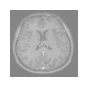

path: test42.jpg / predicted: tumor


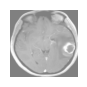

path: test6.JPG / predicted: health


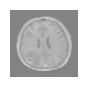

path: test22.jpg / predicted: health


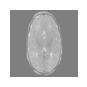

path: test24.jpg / predicted: tumor


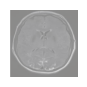

path: test20.jpg / predicted: health


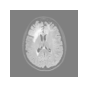

path: test17.jpeg / predicted: health


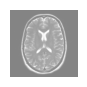

path: test8.jpg / predicted: health


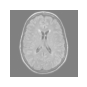

path: test35.JPG / predicted: tumor


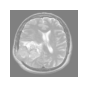

path: test30.JPG / predicted: tumor


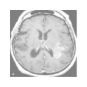

path: test1.jpg / predicted: tumor


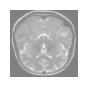

path: test33.JPG / predicted: tumor


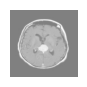

path: test12.jpg / predicted: health


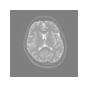

path: test3.jpg / predicted: tumor


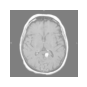

path: test38.JPG / predicted: tumor


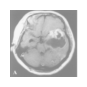

path: test46.JPG / predicted: tumor


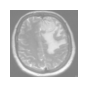

path: test29.JPG / predicted: tumor


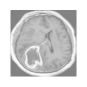

path: test15.jpeg / predicted: health


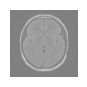

path: test47.JPG / predicted: tumor


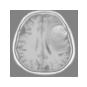

path: test45.JPG / predicted: tumor


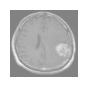

path: test43.JPG / predicted: tumor


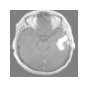

path: test28.jpg / predicted: tumor


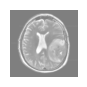

path: test16.jpg / predicted: health


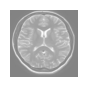

path: test10.JPG / predicted: health


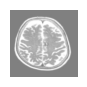

path: test21.jpg / predicted: health


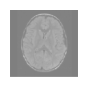

path: test14.jpg / predicted: health


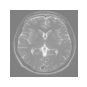

path: test40.JPG / predicted: tumor


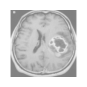

path: test34.JPG / predicted: tumor


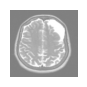

path: test19.png / predicted: health


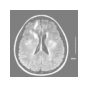

path: test2.jpg / predicted: tumor


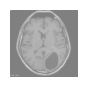

path: test9.JPG / predicted: health


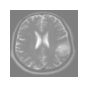

path: test4.jpg / predicted: tumor


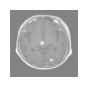

path: test5.jpg / predicted: tumor


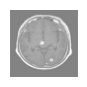

path: test13.jpg / predicted: health


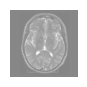

path: test39.JPG / predicted: tumor


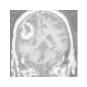

path: test44.JPG / predicted: tumor


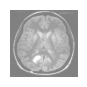

path: test37.JPG / predicted: tumor


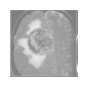

path: test27.jpg / predicted: health


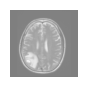

path: test18.jpg / predicted: health


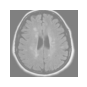

path: test31.JPG / predicted: tumor


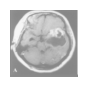

path: test11.jpg / predicted: health


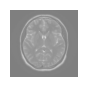

path: test23.jpeg / predicted: health


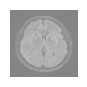

In [ ]:
test_model(model_ft_randstart)

# Visualizing the model predictions

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels, paths) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('path:{} predicted: {}'.format(paths[j].split('/')[7], class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

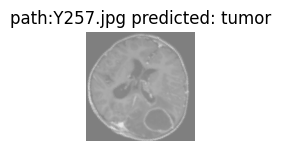

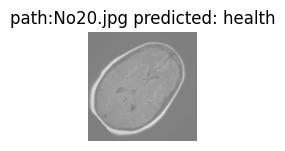

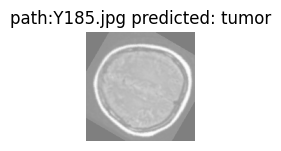

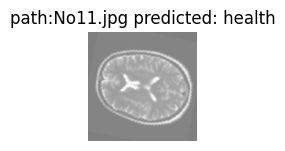

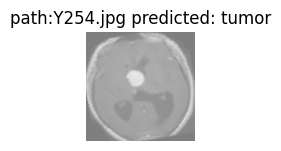

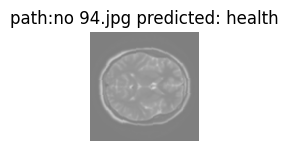

In [ ]:
visualize_model(model_ft_randstart)